In [1]:
install.packages("raster")
install.packages("RItools")

Warning message in install.packages("raster"):
“installation of package ‘raster’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
aoi<-"N14.30728831742391W-13.52951992770953"

In [2]:
#!/usr/bin/env Rscript

# This global processing script PART II is derived from the global processing notebook 
#the input can be the iso3 code (3-character) for one or multiple countries 

#mamba install -c conda-forge r-terra r-optmatch r-sp r-rgdal r-sf r-rgeos r-dplyr r-plyr r-ggplot2 r-raster r-mapview r-stringr r-maptools r-gridExtra r-lattice r-MASS r-foreach r-doParallel r-rlang r-tidyr r-magrittr r-viridis r-ggmap r-Hmisc r-hrbrthemes r-spatialEco r-bit64 r-randomForest r-modelr r-ranger r-caret r-rgeos r-ritools

options(warn=-1)
options(dplyr.summarise.inform = FALSE)

packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr",
              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel","RItools","gdalUtils",
              "rlang","tidyr","magrittr","viridis","ggmap","Hmisc","hrbrthemes","spatialEco","bit64","randomForest", "modelr","ranger","caret")
package.check <- lapply(packages, FUN = function(x) {
  suppressPackageStartupMessages(library(x, character.only = TRUE))
})

args = commandArgs(trailingOnly=TRUE)
if (length(args)==0) {
  stop("At least one argument must be supplied (input file).n", call.=FALSE)
} else if (length(args)>=1) {
  
  iso3 <- args[1]  #country to process
  gediwk <- args[2]   #the # of weeks GEDI data to use
  mproc <- as.integer(args[3])#the number of cores to use for macthing 
}

In [3]:
#Get Info for GPKG Table Name
# ogrInfo(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg",sep=""))

In [70]:
# Subset GEDI data to first 3 features for running troubleshooting
#Run only once!
# sf<- st_read("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg",query = "select * from SEN_admin_L2A limit 3;")
# print(sf)
# st_write(sf,"~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_L2A_subset.gpkg")

In [4]:
iso3 <- "SEN"
gediwk<-24
mproc <-1

cat("Step 0: Loading global variables to process country", iso3,"with GEDI data until week", gediwk, "\n")

f.path <- cat("~/GEDI_PA/Matching_Layers/SEN/")
ecoreg_key <- read.csv(paste("~/GEDI_PA/wwf_ecoregions_key.csv",sep=""))
allPAs <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_PA_poly.rds",sep=""))
MCD12Q1 <- raster(paste("~/GEDI_PA/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep=""))
projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
world_region <- raster(paste("~/GEDI_PA/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep=""))
projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
adm <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_admin.geojson"),verbose=FALSE)
adm_prj <- spTransform(adm, "+init=epsg:6933") 
load("~/GEDI_PA/rf_noclimate.rdata")
source("~/GEDI_PA/matching_func.r") #WILL NEED TO CHANGE FOR FULL GEDI DATASET IN FUTURE
# flag <- "don't ran extraction"
flag <- "run all"
# flag <- "run remaining"

Step 0: Loading global variables to process country SEN with GEDI data until week 24 
~/GEDI_PA/Matching_Layers/SEN/

In [15]:
#Subset GEDI to tiles FOR TESTING

tile<- st_read("~/shared-buckets/abarenblitt/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson")
# spatial filter, as wkt:
wkt = st_as_text(st_geometry(tile[1,]))
print(wkt)
sf<- st_read("~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg", wkt_filter = wkt)
# st_write(sf,"~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l4a_clean_SEN/SEN_L4A_subset_Til1.gpkg")

Reading layer `N14.30728831742391W-13.52951992770953' from data source 
  `/projects/shared-buckets/abarenblitt/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -14.52952 ymin: 14.30729 xmax: -13.52952 ymax: 15.30729
Geodetic CRS:  WGS 84
[1] "POLYGON ((-14.52952 14.30729, -14.52952 15.30729, -13.52952 15.30729, -13.52952 14.30729, -14.52952 14.30729))"
Reading layer `N14.30728831742391W-13.52951992770953.geojson_L2A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 610628 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14

In [6]:
#---------------STEP5. GEDI PROCESSING - using GEDI shots to extract the treatment/control status, also extract the MODIS PFT for AGB prediction---------------- 
# if (file.exists(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",iso3,"_gedi_extracted_matching_wk",gediwk,".RDS", sep=""))){
cat(paste("Step 5: Performing WK ",gediwk,"GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all<-list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
# readr::parse_number() %>% unique()
#list.files(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
registerDoParallel(3)
matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {   #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
stopImplicitCluster()

Step 5: Performing WK  24 GEDI extraction for SEN 


In [7]:
if(flag=="run all"){  #determine how many PAs to run the extraction process
  matched_PAs <- matched_PAs
  cat("Step 5: runing extraction on all", length(matched_PAs),"of non-NA matched results in", iso3,"\n")
} else if (flag=="run remaining"){
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  extracted_PAid <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep=""), full.names = F, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  matched_PA_id <- matched_PAs %>% readr::parse_number()
  runPA_id <- matched_PA_id[!(matched_PA_id %in% extracted_PAid)]
  if (length(runPA_id)>0){
    Pattern2 <-  paste(runPA_id, collapse="|")
    runPA <-  matched_PAs[grepl(Pattern2,matched_PAs)]
    # runPA_ind <- str_detect(matched_PAs, paste(runPA_id, collapse = "|"))
    matched_PAs <-runPA
  } else {
    matched_PAs <- NULL
    cat("Step 5 already done for", iso3, "\n")
  }
}

Step 5: runing extraction on all 108 of non-NA matched results in SEN 


In [8]:
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()

[1] 1

In [165]:
matched_PAs

[1] "SEN_pa_2332_matching_results_wk24.RDS"     
  [2] "SEN_pa_2333_matching_results_wk24.RDS"     
  [3] "SEN_pa_2578_matching_results_wk24.RDS"     
  [4] "SEN_pa_2580_matching_results_wk24.RDS"     
  [5] "SEN_pa_3044_matching_results_wk24.RDS"     
  [6] "SEN_pa_3045_matching_results_wk24.RDS"     
  [7] "SEN_pa_352605_matching_results_wk24.RDS"   
  [8] "SEN_pa_352606_matching_results_wk24.RDS"   
  [9] "SEN_pa_352607_matching_results_wk24.RDS"   
 [10] "SEN_pa_352608_matching_results_wk24.RDS"   
 [11] "SEN_pa_352609_matching_results_wk24.RDS"   
 [12] "SEN_pa_352610_matching_results_wk24.RDS"   
 [13] "SEN_pa_352611_matching_results_wk24.RDS"   
 [14] "SEN_pa_352613_matching_results_wk24.RDS"   
 [15] "SEN_pa_352614_matching_results_wk24.RDS"   
 [16] "SEN_pa_352615_matching_results_wk24.RDS"   
 [17] "SEN_pa_352616_matching_results_wk24.RDS"   
 [18] "SEN_pa_352617_matching_results_wk24.RDS"   
 [19] "SEN_pa_352618_matching_results_wk24.RDS"   
 [20] "SEN_pa_352619_matching_results_wk24.RDS"   
 [21] "SEN_pa_352620_matching_results_wk24.RDS"   
 [22] "SEN_pa_352621_matching_results_wk24.RDS"   
 [23] "SEN_pa_352622_matching_results_wk24.RDS"   
 [24] "SEN_pa_352623_matching_results_wk24.RDS"   
 [25] "SEN_pa_352624_matching_results_wk24.RDS"   
 [26] "SEN_pa_352625_matching_results_wk24.RDS"   
 [27] "SEN_pa_352626_matching_results_wk24.RDS"   
 [28] "SEN_pa_352627_matching_results_wk24.RDS"   
 [29] "SEN_pa_352628_matching_results_wk24.RDS"   
 [30] "SEN_pa_352629_matching_results_wk24.RDS"   
 [31] "SEN_pa_352630_matching_results_wk24.RDS"   
 [32] "SEN_pa_352631_matching_results_wk24.RDS"   
 [33] "SEN_pa_352632_matching_results_wk24.RDS"   
 [34] "SEN_pa_352633_matching_results_wk24.RDS"   
 [35] "SEN_pa_352634_matching_results_wk24.RDS"   
 [36] "SEN_pa_352635_matching_results_wk24.RDS"   
 [37] "SEN_pa_352636_matching_results_wk24.RDS"   
 [38] "SEN_pa_352637_matching_results_wk24.RDS"   
 [39] "SEN_pa_352638_matching_results_wk24.RDS"   
 [40] "SEN_pa_352639_matching_results_wk24.RDS"   
 [41] "SEN_pa_352640_matching_results_wk24.RDS"   
 [42] "SEN_pa_352641_matching_results_wk24.RDS"   
 [43] "SEN_pa_352642_matching_results_wk24.RDS"   
 [44] "SEN_pa_352643_matching_results_wk24.RDS"   
 [45] "SEN_pa_352644_matching_results_wk24.RDS"   
 [46] "SEN_pa_352645_matching_results_wk24.RDS"   
 [47] "SEN_pa_352646_matching_results_wk24.RDS"   
 [48] "SEN_pa_352647_matching_results_wk24.RDS"   
 [49] "SEN_pa_352648_matching_results_wk24.RDS"   
 [50] "SEN_pa_352649_matching_results_wk24.RDS"   
 [51] "SEN_pa_352650_matching_results_wk24.RDS"   
 [52] "SEN_pa_352651_matching_results_wk24.RDS"   
 [53] "SEN_pa_352653_matching_results_wk24.RDS"   
 [54] "SEN_pa_352654_matching_results_wk24.RDS"   
 [55] "SEN_pa_352655_matching_results_wk24.RDS"   
 [56] "SEN_pa_352656_matching_results_wk24.RDS"   
 [57] "SEN_pa_352657_matching_results_wk24.RDS"   
 [58] "SEN_pa_352658_matching_results_wk24.RDS"   
 [59] "SEN_pa_352659_matching_results_wk24.RDS"   
 [60] "SEN_pa_352660_matching_results_wk24.RDS"   
 [61] "SEN_pa_352661_matching_results_wk24.RDS"   
 [62] "SEN_pa_352662_matching_results_wk24.RDS"   
 [63] "SEN_pa_352663_matching_results_wk24.RDS"   
 [64] "SEN_pa_352664_matching_results_wk24.RDS"   
 [65] "SEN_pa_352665_matching_results_wk24.RDS"   
 [66] "SEN_pa_352666_matching_results_wk24.RDS"   
 [67] "SEN_pa_352667_matching_results_wk24.RDS"   
 [68] "SEN_pa_352668_matching_results_wk24.RDS"   
 [69] "SEN_pa_352669_matching_results_wk24.RDS"   
 [70] "SEN_pa_352670_matching_results_wk24.RDS"   
 [71] "SEN_pa_352671_matching_results_wk24.RDS"   
 [72] "SEN_pa_352672_matching_results_wk24.RDS"   
 [73] "SEN_pa_352673_matching_results_wk24.RDS"   
 [74] "SEN_pa_352674_matching_results_wk24.RDS"   
 [75] "SEN_pa_352675_matching_results_wk24.RDS"   
 [76] "SEN_pa_352676_matching_results_wk24.RDS"   
 [77] "SEN_pa_352677_matching_results_wk24.RDS"   
 [78] "SEN_pa_352678_matching_results_wk24.RDS"   
 [79] "SEN_pa_352679_mat

In [75]:
#FOR FULL DATASET
# foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
#   cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
#   if(nchar(iso3)>3){
#     id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
#   } else {
#     id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
#   }
#   matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
#   if (is.null(matched)==TRUE  | nrow(matched)==0) {
#     cat("Matched result is null for PA", id_pa, "quitting...\n")
#   } else if (!is.null(matched)==TRUE){
#     mras  <- tryCatch(matched2ras(matched),
#                       error=function(cond){
#                         message(cond)
#                         cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
#                         # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
#                         return(NULL)}) #convert the macthed df to a raster stack 
#     if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
#       cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
#     } else {
#       startTime <- Sys.time()
#       iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)  #run filtered csvs on mras for extarction
#       tElapsed <- Sys.time()-startTime
#     iso_matched_gedi<- matched
#       cat(tElapsed, "for extracting all PAs in", iso3,"\n")
#       iso_matched_gedi_sub <- iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         dplyr::select("pa_id","status","wwfbiom","wwfecoreg","lon_lowestmode","lat_lowestmode",
#                       "rh_010","rh_020", "rh_030", "rh_040",  "rh_050",  "rh_060" , "rh_070","rh_075",  "rh_080",  "rh_090",  "rh_098", "AGBD","cover","pai","REGION","PFT")  #write to individual country folder
#       if (length(unique(iso_matched_gedi$wwfbiom)) >1){
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
#       } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
#       } else {
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique()
#       }
#       # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
#       continent <- unique(iso_matched_gedi$region) %>% getmode()

#       dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
#       saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
#       cat(id_pa,"in",iso3,"results is written to dir\n")
#       write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
#     }
#   }
#   return(NULL)
# }

# stopImplicitCluster()
# tElapsed <- Sys.time()-startTime
# cat(tElapsed, "for extracting all PAs in", iso3,"\n")
# cat("Done GEDI extraction for pa in ",iso3,"\n")    

In [ ]:
# TESTING FOR SING RDS

foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
  cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS", sep=""))
  if (is.null(matched)==TRUE  | nrow(matched)==0) {
    cat("Matched result is null for PA", id_pa, "quitting...\n")
  } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        return(NULL)}) #convert the macthed df to a raster stack 
    mras<-projectRaster(mras,crs = crs(tile))
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)  #run filtered csvs on mras for extarction
      tElapsed <- Sys.time()-startTime
    iso_matched_gedi<- matched
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      iso_matched_gedi_sub <- iso_matched_gedi %>%
        #ASK AMBER ABOUT OG COLUMNS
        #THIS NEEDS TO BE ADJUSTED!!!!
        dplyr::select("pa_id","status",
                      # "wwfbiom","wwfecoreg","lon_lowestmode","lat_lowestmode",
                      "shot_number")
                      # ,"lon_lowestmode", "lat_lowestmode","rh25", "rh50", "rh75","rh90", "rh98")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    }
  }
  return(NULL)
}

stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

In [39]:
stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

16.5027 for extracting all PAs in SEN 
Done GEDI extraction for pa in  SEN 


### below is testing how to extract the GEDI data for one PA's matching results 5/16

In [103]:
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", "2332","_matching_results_wk",gediwk,".RDS", sep=""))
print(matched)

# A tibble: 12,806 × 21
     lat   lon   UID status land_cover     wwfbiom    wwfecoreg elevation  slope
   <dbl> <dbl> <int> <lgl>  <fct>          <fct>      <fct>         <dbl>  <dbl>
 1  14.6 -13.8    35 TRUE   l2_grassland   Tropical … West Sud…        52 0.428 
 2  14.7 -13.7   120 TRUE   l3_agriculture Tropical … West Sud…        46 0.312 
 3  14.9 -13.6   131 TRUE   l2_grassland   Tropical … West Sud…        69 0.0386
 4  14.5 -13.9   143 TRUE   l2_grassland   Tropical … West Sud…        56 0.0556
 5  14.5 -13.8   150 TRUE   l2_grassland   Tropical … West Sud…        59 0.0556
 6  14.9 -13.5   183 TRUE   l2_grassland   Tropical … Sahelian…        63 0.143 
 7  14.7 -13.7   204 TRUE   l2_grassland   Tropical … West Sud…        60 0.309 
 8  14.5 -13.9   228 TRUE   l2_grassland   Tropical … West Sud…        57 0.0556
 9  14.6 -13.8   236 TRUE   l2_grassland   Tropical … West Sud…        54 0.278 
10  14.9 -13.5   268 TRUE   l2_grassland   Tropical … Sahelian…        67 0.143 
# ℹ 

In [104]:
mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 

SEN converting the matched csv to a raster stack for extraction


In [116]:
mrasProj <- projectRaster(mras,crs = crs(tile))

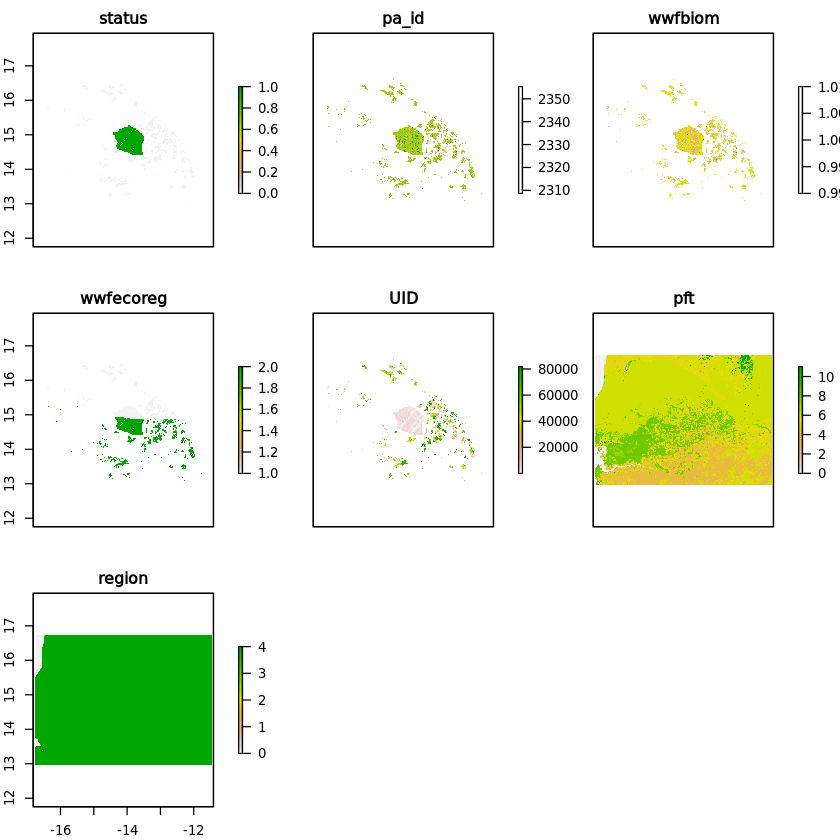

In [117]:
plot(mrasProj)


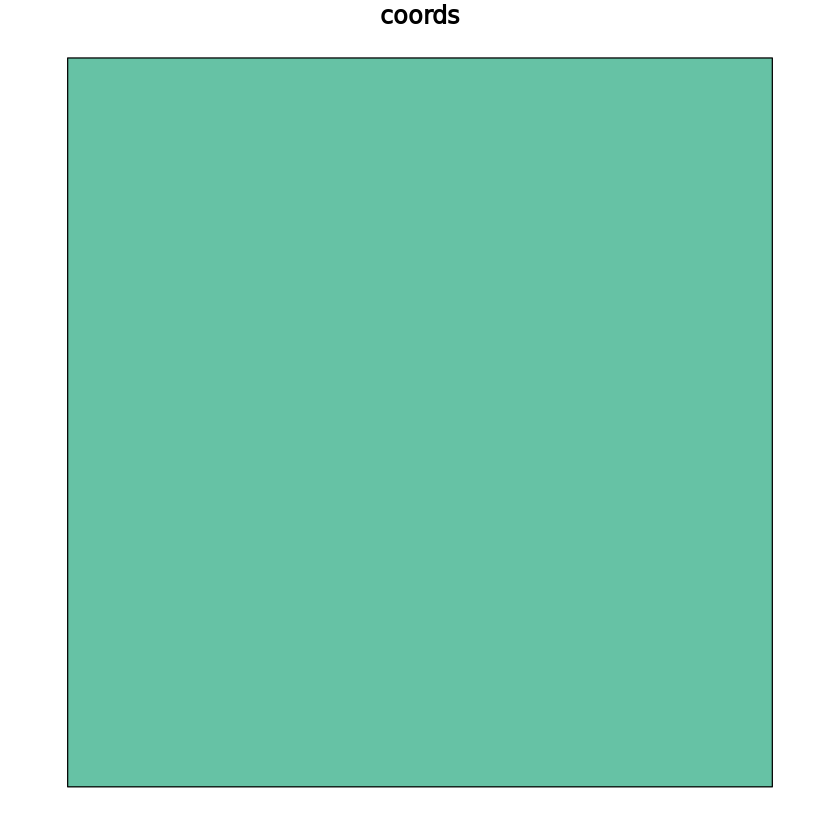

In [108]:
plot(tile)

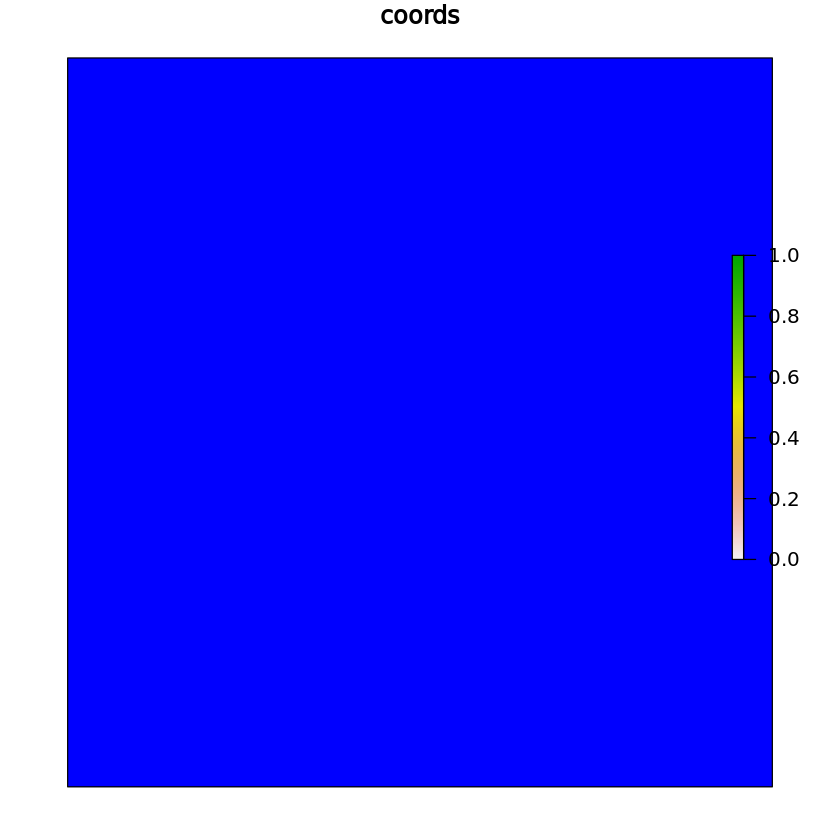

In [114]:
plot(tile, ,col="blue")


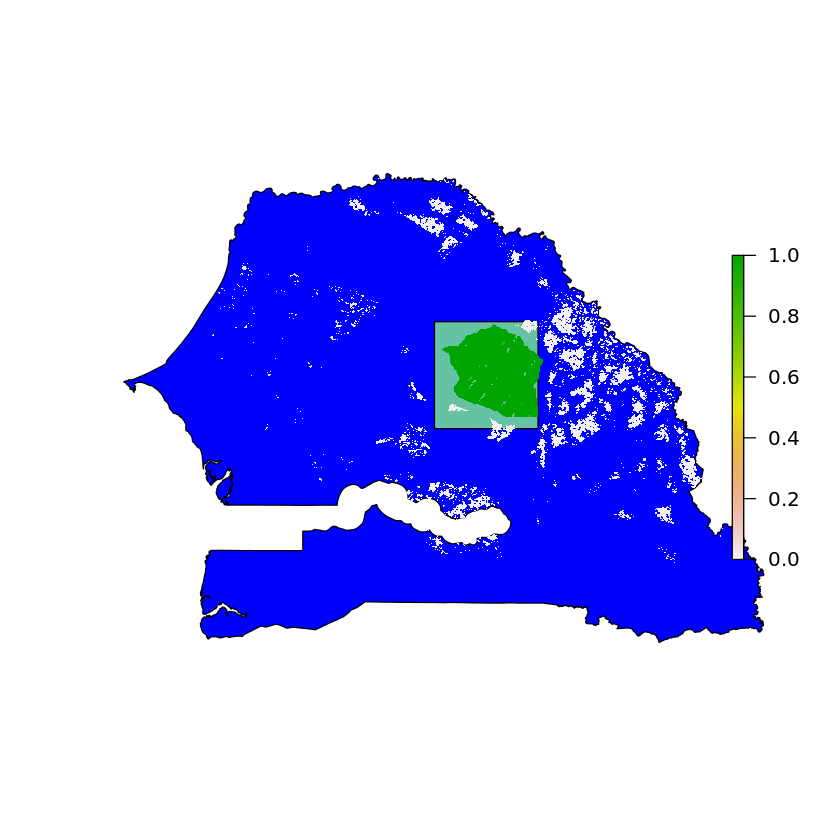

In [118]:
plot(adm, col = "blue")
plot(tile, add = TRUE)
plot(mrasProj$status,add = TRUE)

In [90]:
# essentially we want to extract gedi shots over the raster grids, but the extract_gedi function needs customization [done below]
# iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)

In [158]:
f.path <- '~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles'
list.files(file.path(f.path), full.names = TRUE, pattern = '.gpkg') 

[1] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-10.52951992770953.geojson_L2B.gpkg"
  [2] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-10.52951992770953.geojson_L4A.gpkg"
  [3] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
  [4] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-11.52951992770953.geojson_L2B.gpkg"
  [5] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-11.52951992770953.geojson_L4A.gpkg"
  [6] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
  [7] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-12.52951992770953.geojson_L4A.gpkg"
  [8] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
  [9] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-13.52951992770953.geojson_L2B.gpkg"
 [10] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-13.52951992770953.geojson_L4A.gpkg"
 [11] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
 [12] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-14.52951992770953.geojson_L2B.gpkg"
 [13] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-14.52951992770953.geojson_L4A.gpkg"
 [14] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-15.52951992770953.geojson_L2A.gpkg"
 [15] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-15.52951992770953.geojson_L2B.gpkg"
 [16] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-15.52951992770953.geojson_L4A.gpkg"
 [17] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-16.52951992770953.geojson_L2A.gpkg"
 [18] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-16.52951992770953.geojson_L2B.gpkg"
 [19] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-16.52951992770953.geojson_L4A.gpkg"
 [20] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-17.52951992770953.geojson_L2A.gpkg"
 [21] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N12.30728831742391W-17.52951992770953.geojson_L2B.gpkg"
 [22] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-10.52951992770953.geojson_L2A.gpkg"
 [23] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-10.52951992770953.geojson_L2B.gpkg"
 [24] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-10.52951992770953.geojson_L4A.gpkg"
 [25] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-11.52951992770953.geojson_L2A.gpkg"
 [26] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-11.52951992770953.geojson_L2B.gpkg"
 [27] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-11.52951992770953.geojson_L4A.gpkg"
 [28] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-12.52951992770953.geojson_L2A.gpkg"
 [29] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-12.52951992770953.geojson_L2B.gpkg"
 [30] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-12.52951992770953.geojson_L4A.gpkg"
 [31] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-13.52951992770953.geojson_L2A.gpkg"
 [32] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-13.52951992770953.geojson_L2B.gpkg"
 [33] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-13.52951992770953.geojson_L4A.gpkg"
 [34] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-14.52951992770953.geojson_L2A.gpkg"
 [35] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-14.52951992770953.geojson_L2B.gpkg"
 [36] "/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N13.30728831742391W-14.52951992770953.geojson_L4A.gpkg"
 [37] 

In [125]:
mrasProj <- projectRaster(mras,crs = crs(read))

## this is re-writing the extract_gedi() function 

In [154]:
#Testing extract_gedi over a single tile of gedi data
extract_gedi <- function(matched, mrasProj){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/'
    all_gedil2_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg') 
    all_gedil4_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L4A.gpkg') 
    
    registerDoParallel(cores=1)
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")
#         gedi_l2  <- st_read(all_gedil2_f[this_csvid]) %>%as.data.frame()%>%
#             dplyr::select(shot_number,lon_lowestmode, lat_lowestmode,rh25, rh50, rh75,rh90, rh98)

#         gedi_l4  <- st_read(all_gedil4_f[this_csvid]) %>% as.data.frame()
#         if (nrow(gedi_l4) < 1){   #is.na(gedi_l4) || 
#           cat("error")
#           gedi_l24 <- gedi_l2
#           gedi_l24$agbd <- NA
#           gedi_l24$agbd_se <- NA
#           gedi_l24$agbd_t <- NA
#           gedi_l24$agbd_t_se <- NA
#         } else {
#           gedi_l4_sub <- gedi_l4 %>%
#             dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
#           gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")

#         }
        gedi_l4 <- as.data.frame(all_gedil4_f)
        gedi_l2 <- as.data.frame(all_gedil2_f)
            if (nrow(gedi_l4) < 1){   #is.na(gedi_l4) || 
              cat("error")
              gedi_l24 <- gedi_l2
              gedi_l24$agbd <- NA
              gedi_l24$agbd_se <- NA
              gedi_l24$agbd_t <- NA
              gedi_l24$agbd_t_se <- NA
            } else {
              gedi_l4_sub <- gedi_l4 %>%
                dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
              gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")

            }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mrasProj,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(dim(iso_matched_gedi_df))
        }

        return(iso_matched_gedi_df)
}
    
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
}

In [156]:
extract_gedi(matched=matched, mras = mrasProj)

Reading layer `N14.30728831742391W-13.52951992770953.geojson_L2A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 610628 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14.52952 ymin: 14.30729 xmax: -13.52952 ymax: 15.30728
Geodetic CRS:  WGS 84
Reading layer `N14.30728831742391W-13.52951992770953.geojson_L4A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 252185 features and 16 field

ID,status,pa_id,wwfbiom,wwfecoreg,UID,pft,region,filename,rh25,⋯,rh75,shot_number,lon_lowestmode,lat_lowestmode,geom,agbd,agbd_se,agbd_t,agbd_t_se,stratum
<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<POINT [°]>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
878,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.34,⋯,0.71,2.14705e+16,-14.30677,14.47649,POINT (-14.30677 14.47649),1.0753418,3.006936,0.9806511,1.639847,NA_Af
879,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.23,⋯,0.74,2.14705e+16,-14.30645,14.47690,POINT (-14.30645 14.4769),1.0753418,3.006936,0.9806511,1.639847,NA_Af
880,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.23,⋯,0.74,2.14705e+16,-14.30613,14.47731,POINT (-14.30613 14.47731),1.0753418,3.006936,0.9806511,1.639847,NA_Af
881,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.23,⋯,0.71,2.14705e+16,-14.30581,14.47773,POINT (-14.30581 14.47773),0.9703503,3.007645,0.9315487,1.640041,NA_Af
882,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.31,⋯,0.71,2.14705e+16,-14.30549,14.47814,POINT (-14.30549 14.47814),0.9703503,3.007645,0.9315487,1.640041,NA_Af
883,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.27,⋯,0.74,2.14705e+16,-14.30517,14.47855,POINT (-14.30517 14.47855),0.9703503,3.007645,0.9315487,1.640041,NA_Af
884,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.27,⋯,0.74,2.14705e+16,-14.30485,14.47896,POINT (-14.30485 14.47896),0.9703503,3.007645,0.9315487,1.640041,NA_Af
885,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.31,⋯,0.71,2.14705e+16,-14.30453,14.47938,POINT (-14.30453 14.47938),0.9703503,3.007645,0.9315487,1.640041,NA_Af
886,0,2332,"Tropical & Subtropical Grasslands, Savannas & Shrublands",West Sudanian savanna,3655.000,NA,Af,GEDI02_A_2019120024524_O02147_02_T05306_02_003_01_V002.h5,-1.19,⋯,0.74,2.14705e+16,-14.30421,14.47979,POINT (-14.30421 14.47979),1.2284364,3.005978,1.0481359,1.639586,NA_Af


### here we dive into the extract_gedi function, but will work around the old GEDI product structure, to use the MAAP-derived verions

In [132]:
# This tile covers PA 2332
all_gedil2_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg')  #testing with one subset of l2a
print(dim(all_gedil2_f))
print(class(all_gedil2_f))

Reading layer `N14.30728831742391W-13.52951992770953.geojson_L2A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 610628 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14.52952 ymin: 14.30729 xmax: -13.52952 ymax: 15.30728
Geodetic CRS:  WGS 84
[1] 610628     11
[1] "sf"         "data.frame"


In [134]:
all_gedil4_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L4A.gpkg')  #testing with one subset of l2b 
print(dim(all_gedil4_f))
print(class(all_gedil4_f))

Reading layer `N14.30728831742391W-13.52951992770953.geojson_L4A' from data source `/projects/GEDI_PA/Matching_Layers/SEN/SEN_Tiles/N14.30728831742391W-13.52951992770953.geojson_L4A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 252185 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -14.52952 ymin: 14.3073 xmax: -13.52952 ymax: 15.30728
Geodetic CRS:  WGS 84
[1] 252185     17
[1] "sf"         "data.frame"


In [143]:
gedi_l4 <- as.data.frame(all_gedil4_f)
gedi_l2 <- as.data.frame(all_gedil2_f)
if (nrow(gedi_l4) < 1){   #is.na(gedi_l4) || 
          cat("error")
          gedi_l24 <- gedi_l2
          gedi_l24$agbd <- NA
          gedi_l24$agbd_se <- NA
          gedi_l24$agbd_t <- NA
          gedi_l24$agbd_t_se <- NA
        } else {
          gedi_l4_sub <- gedi_l4 %>%
            dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
          gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")
        
        }

In [137]:
# gedi_l24[rowSums(is.na(gedi_l24)) > 0, ]   
# gedi_l24 <- left_join(gedi_l2, gedi_l4, by="shot_number") #%>% drop_na()
print(dim(gedi_l24))
iso_matched_gedi_df <- data.frame()
if(nrow(gedi_l24)>0){
    gedi_l24_sp <- gedi_l24 %>% 
        SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                             proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

    matched_gedi <- raster::extract(mrasProj,gedi_l24_sp, df=TRUE)
    matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
    matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
      convertFactor(matched0 = matched,exgedi = .) 

    iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
    print(dim(iso_matched_gedi_df))
}

[1] 4995792      15
[1] 2711867      24


## this is the end of the extract_gedi() function for single l2/l4 file 

In [138]:
shape <- read_sf(read)

ERROR: Error in if (nchar(dsn) < 1) stop("`dsn` must point to a source, not an empty string.", : the condition has length > 1


In [ ]:
shape

In [15]:
all_gedil2_f<-st_read(all_gedil2_f)
print(dim(all_gedil2_f))
print(class(all_gedil2_f))

Reading layer `SEN_admin_L2A' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 12774217 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -17.52855 ymin: 12.30903 xmax: -11.34619 ymax: 16.69272
Geodetic CRS:  WGS 84
[1] 12774217       11
[1] "sf"         "data.frame"


In [ ]:
gedil2 <- all_gedil2_f %>%
                as.data.frame() %>%
                # dplyr::select(lon_lowestmode, lat_lowestmode) #%>%
                # mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
                # mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) 
l2_latlon <- gedil2_f %>% dplyr::select(lon_lowestmode, lat_lowestmode) #%>%paste(sep="_", collapse ="_") %>% paste("_",.,sep="")

names(gedil2_f)

In [30]:
l2_latlon

ERROR: Error in eval(expr, envir, enclos): object 'l2_latlon' not found


In [149]:
extract_gedi <- function(matched, mrasProj){
    lon_bond <- range(matched$lon,na.rm=TRUE)
    # lat_bond <- range(matched$lat,na.rm=TRUE)
    # gedi_folder <- paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN")
    # all_gedil2_f <- read_sf(list.files(gedi_folder,full.names=TRUE)) 
    # # all_gedil4_f <- list.files(file.path(f.path,"WDPA_gedi_l4a_clean",iso3), full.names = FALSE) 
    # gedil2_f <- all_gedil2_f%>% strsplit( "_") %>% 
    #   as.data.frame() %>% 
    #   t() %>% as.data.frame(row.names =all_gedil2_f, stringsAsFactors=FALSE,make.names=FALSE) %>% dplyr::select(V3,V4) %>% 
    #   mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
    #   mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) %>% 
    #   mutate( lons = ifelse(ew!="E", -1*lons, lons)) %>% 
    #   mutate( lats = ifelse(ns!="N", -1*lats, lats)) %>% 
    #   dplyr::filter( between(lons, floor(lon_bond[1]), ceiling(lon_bond[2]))) %>% 
    #   dplyr::filter(between(lats, floor(lat_bond[1]), ceiling(lat_bond[2]))) %>% rownames()
#     gedil4_f <- all_gedil4_f%>% strsplit( "_") %>% 
#       as.data.frame() %>% 
#       t() %>% as.data.frame(row.names =all_gedil4_f, stringsAsFactors=FALSE,make.names=FALSE) %>% dplyr::select(V3,V4) %>% 
#       mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
#       mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) %>% 
#       mutate( lons = ifelse(ew!="E", -1*lons, lons)) %>% 
#       mutate( lats = ifelse(ns!="N", -1*lats, lats)) %>% 
#       dplyr::filter( between(lons, floor(lon_bond[1]), ceiling(lon_bond[2]))) %>% 
#       dplyr::filter(between(lats, floor(lat_bond[1]), ceiling(lat_bond[2]))) %>% rownames()  #should result in same # of files as the l2 products
    
    registerDoParallel(cores=1)
    ex_out <- foreach(this_csvid=seq(length(gedil2_f)), .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(gedil2_f),"csvs for iso3",iso3,"\n")
        # gedi_l2  <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN",gedil2_f[this_csvid], sep="/")) %>%
        #   dplyr::select(shot_number,lon_lowestmode, lat_lowestmode,rh_025, rh_050, rh_075, rh_098,cover, pai)
        # l2_latlon <- gedil2_f[this_csvid] %>%  str_split("_") %>% unlist %>% .[3:4] %>% paste(sep="_", collapse ="_") %>% paste("_",.,sep="")
        # l4_pattern <- tryCatch(grep(l2_latlon, gedil4_f, value=TRUE), error=function(cond){return(NA)})
        # gedi_l4  <- tryCatch(read.csv(paste(f.path,"WDPA_gedi_l4a_clean",iso3,l4_pattern, sep="/")), error=function(cond){return(NA)})
                            
#         if (is.na(gedi_l4) || nrow(gedi_l4) < 1){
#           cat("error")
#           gedi_l24 <- gedi_l2
#           gedi_l24$agbd <- NA
#           gedi_l24$agbd_se <- NA
#           gedi_l24$agbd_t <- NA
#           gedi_l24$agbd_t_se <- NA
#         } else {
#           gedi_l4_sub <- gedi_l4 %>%
#             dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
#           gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")
        
#         }
      # gedi_l24[rowSums(is.na(gedi_l24)) > 0, ]   
      # gedi_l24 <- left_join(gedi_l2, gedi_l4, by="shot_number") %>% drop_na()
      iso_matched_gedi_df <- data.frame()   #after l2 and l4 are joined, this is extracting
#       if(nrow(gedi_l24)>0){
#         gedi_l24_sp <- gedi_l24 %>% 
#           SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
#                                  proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))
        
#         matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
#         matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
#         matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
#           convertFactor(matched0 = matched,exgedi = .) 
        
#         iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
        
#       }
      return(iso_matched_gedi_df)
  }
  stopImplicitCluster()
  cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
  return(ex_out)
}

In [148]:
extract_gedi(matched=matched, mras = mrasProj)

ERROR: Error in eval(a, envir = extra, enclos = obj$evalenv): object 'gedil2_f' not found
